# La Réunion: download and plot

This minimal notebook downloads a GMRT GeoTIFF for La Réunion and plots it on a map.

- Bounds (lon/lat): [55.0, -21.5, 56.0, -20.5]
- Format: geotiff (medium resolution)
- Output folder: ./data

In [ ]:
# Minimal setup for this notebook (idempotent)
import sys
import subprocess
import pathlib
import shutil


def have_uv() -> bool:
    return shutil.which("uv") is not None


def pip_install(pkgs):
    print("Installing:", pkgs)
    if have_uv():
        subprocess.check_call(["uv", "pip", "install", "-q", *pkgs])
    else:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "-q", *pkgs]
        )


# Ensure local package is importable (prefer editable install; fallback to src path)
PROJECT_ROOT = (
    str(pathlib.Path(__file__).resolve().parents[1])
    if "__file__" in globals()
    else str(pathlib.Path.cwd().parent)
)
try:
    pip_install(["-e", PROJECT_ROOT])
except Exception:
    pass
try:
    import pygmrt  # noqa: F401
except Exception:
    src_path = str(pathlib.Path(PROJECT_ROOT) / "src")
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
    import pygmrt  # noqa: F401

# Viz deps
try:
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import rasterio
except Exception:
    pip_install(["cartopy", "matplotlib", "rasterio"])  # may take a minute
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import rasterio

print("Ready.")

Installing: ['-e', '/Users/seydoux/Desktop/pygmrt']
Ready.


## Quick import and help

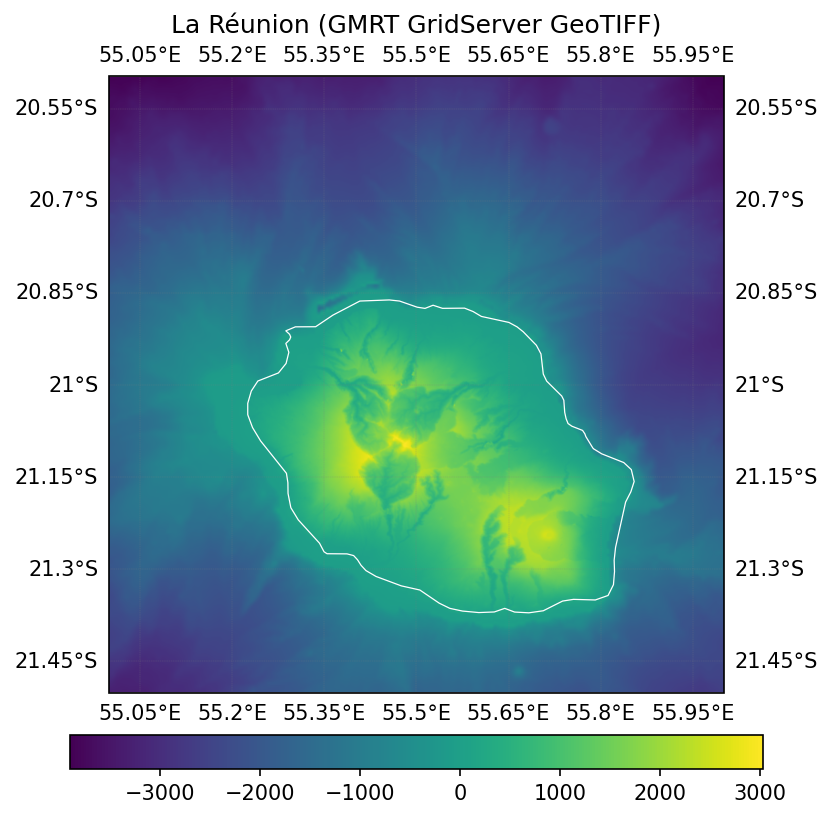

In [17]:
# Download a GeoTIFF of La Réunion and plot it using GMRT GridServer (no API key)
from pathlib import Path
from pygmrt.tiles import download_tiles
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import rasterio

# La Réunion bbox [minLon, minLat, maxLon, maxLat]
bbox = [55.0, -21.5, 56.0, -20.5]
dest = "./data"

# Use GMRT provider (default) for GeoTIFF; force re-download to avoid stale/corrupt cache
result = download_tiles(
    bbox=bbox,
    dest=dest,
    format="geotiff",
    resolution="low",
    provider="gmrt",
    overwrite="overwrite",
)

# Find a created/reused GeoTIFF path
tif_path = None
for e in result.entries:
    p = Path(e.path)
    if (
        e.status in ("created", "reused")
        and p.exists()
        and p.suffix.lower() in (".tif", ".tiff")
    ):
        tif_path = p
        break
if tif_path is None:
    raise RuntimeError(
        "No GeoTIFF returned. Check API availability or parameters."
    )

# Plot
with rasterio.open(tif_path) as src:
    band1 = src.read(1)
    b = src.bounds
    extent = (b.left, b.right, b.bottom, b.top)

    fig, ax = plt.subplots(
        subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 6), dpi=150
    )
    im = ax.imshow(
        band1,
        extent=extent,
        origin="upper",
        transform=ccrs.PlateCarree(),
        cmap="viridis",
    )
    ax.gridlines(
        draw_labels=True,
        linewidth=0.2,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    ax.coastlines("10m", color="white", linewidth=0.6, zorder=10)
    ax.set_title("La Réunion (GMRT GridServer GeoTIFF)")
    plt.colorbar(im, ax=ax, orientation="horizontal", fraction=0.05, pad=0.06)
    plt.show()